In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats
from astropy.table import Table

import emcee
import corner

from collections import OrderedDict
import time

# Crater 2

This is data taken from AAT/AAO as part of the S5 collaboration (Ji et al. in prep).
We targeted a diffuse dwarf galaxy Crater 2 and want to measure its velocity and metallicity dispersion.
We obtained multifiber spectroscopy of ~300 stars and used a pipeline to measure the radial velocities and metallicities, obtaining ~150 stars with good measurements.
Within the field of view, targets are selected based off of their color-magnitude diagrams and proper motions. This can still leave substantial contamination from disk or halo stars that can be separated using the stellar velocities and metallicities.

We will fit a Gaussian mixture model to this data using `emcee`.

In [2]:
tab = Table.read("DR2.2beta_extra_Crater2.fits")

In [3]:
quality_cuts = (tab["best_sn_1700d"] > 4) & (tab["vel_calib_std"] < 10) & (np.abs(tab["vel_calib"]) < 500)
tab = tab[quality_cuts]

## Remove bad [Fe/H] without removing their velocity
tab["feh_calib_std"][tab["feh_calib_std"] > 0.5] = 99.
## Remove binary candidates without removing their feh
tab["vel_calib_std"][tab["bincand"]] = 999.

In [4]:
len(tab)

149

In [5]:
tab.colnames

['vel_calib',
 'vel_calib_std',
 'feh50',
 'feh_calib_std',
 'best_sn_1700d',
 'bincand']

[Text(0.5, 0, '[Fe/H] (dex)'),
 Text(0, 0.5, 'vhel (km/s)'),
 (-4.0, 1.0),
 (-100.0, 400.0)]

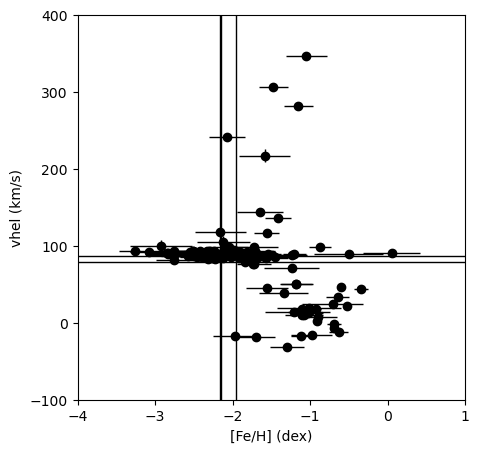

In [6]:
## Pull out the relevant data columns
rv = tab["vel_calib"] # heliocentric radial velocity
rverr = tab["vel_calib_std"]

feh = tab["feh50"]
feherr = tab["feh_calib_std"]

fig, ax = plt.subplots(figsize=(5,5))
ax.errorbar(feh, rv, xerr=feherr, yerr=rverr, fmt='o', elinewidth=1, color='k')
ax.set(xlabel="[Fe/H] (dex)", ylabel="vhel (km/s)", xlim=(-4,1), ylim=(-100,400))


Text(0.5, 0, '[Fe/H]')

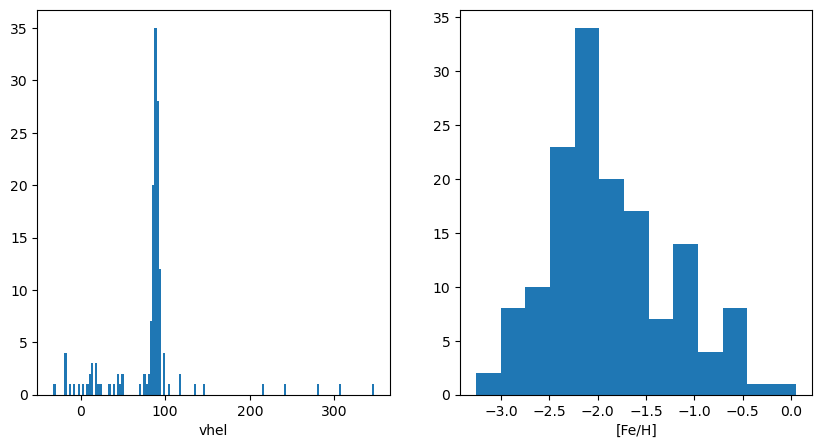

In [7]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].hist(rv, bins='auto');
axes[0].set_xlabel("vhel")
axes[1].hist(feh, bins='auto');
axes[1].set_xlabel("[Fe/H]")

By eye, there are 2-3 components. We will model these as a mixture of 3 gaussians. The parameters will be:

* pgal = fraction of stars in the galaxy
* pbg1 = fraction of stars in the 1st background component
* vhel = mean velocity of the galaxy in km/s
* lsigv = log10 the velocity dispersion of the galaxy in km/s
* feh = mean metallicity of the galaxy in dex
* lsigfeh = log10 the metallicity dispersion of the galaxy in dex
* vbg1, lsigvbg1, fehbg1, lsigfeh1 = same parameters for 1st background component
* vbg2, lsigvbg2, fehbg2, lsigfeh2 = same parameters for 2nd background component

In total there are 14 parameters.

# Likelihood function

In [8]:
param_labels = ["pgal","pbg1",
                "vhel","lsigv","feh","lsigfeh",
                "vbg1","lsigvbg1","fehbg1","lsigfeh1",
                "vbg2","lsigvbg2","fehbg2","lsigfeh2"]
def lnprob(theta, rv, rverr, feh, feherr):
    """ Likelihood and Prior """
    pgal, pbg1, \
    vhel, lsigv, feh0, lsigfeh, \
    vbg1, lsigvbg1, fehbg1, lsigfeh1, \
    vbg2, lsigvbg2, fehbg2, lsigfeh2 = theta
    
    ## The prior is just a bunch of hard cutoffs
    if (pgal > 1) or (pgal < 0) or (pbg1 > 1) or (pbg1 < 0) or \
        (lsigv > 3) or (lsigvbg1 > 3) or (lsigvbg2 > 3) or \
        (lsigv < -1) or (lsigvbg1 < -1) or (lsigvbg2 < -1) or \
        (lsigfeh > 1) or (lsigfeh1 > 1) or (lsigfeh1 > 1) or \
        (lsigfeh < -3) or (lsigfeh1 < -3) or (lsigfeh1 < -3) or \
        (vhel > 150) or (vhel < 50) or (vbg1 > 500) or (vbg1 < 50) or \
        (vbg2 > 50) or (vbg2 < -50):
        return -1e10 # outside of prior, return a tiny number
    
    ## Compute log likelihood in rv
    lgal_vhel = stats.norm.logpdf(rv, loc=vhel, scale=np.sqrt(rverr**2 + (10**lsigv)**2))
    lbg1_vhel = stats.norm.logpdf(rv, loc=vbg1, scale=np.sqrt(rverr**2 + (10**lsigvbg1)**2))
    lbg2_vhel = stats.norm.logpdf(rv, loc=vbg2, scale=np.sqrt(rverr**2 + (10**lsigvbg2)**2))
    
    ## Compute log likelihood in feh
    lgal_feh = stats.norm.logpdf(feh, loc=feh0,    scale=np.sqrt(feherr**2 + (10**lsigfeh)**2))
    lbg1_feh = stats.norm.logpdf(feh, loc=fehbg1, scale=np.sqrt(feherr**2 + (10**lsigfeh1)**2))
    lbg2_feh = stats.norm.logpdf(feh, loc=fehbg2, scale=np.sqrt(feherr**2 + (10**lsigfeh2)**2))
    
    ## Note: If for some reason you have covariances, e.g. for Gaia proper motions, 
    ## you can use stats.multivariate_normal.logpdf
    
    ## Combine the components
    lgal = np.log(pgal) + lgal_vhel + lgal_feh
    lbg1 = np.log(pbg1) + lbg1_vhel + lbg1_feh
    lbg2 = np.log(1-pbg1) + lbg2_vhel + lbg2_feh
    ## np.logaddexp takes the exp, adds them, and re-lns them in a numerically stable way
    lbgtot = np.logaddexp(lbg1, lbg2)
    ltot = np.logaddexp(lgal, np.log(1-pgal) + lbgtot)
    
    return np.sum(ltot)

def get_paramdict(theta):
    return OrderedDict(zip(param_labels, theta))
def project_model(theta, rvmin=-200, rvmax=500, fehmin=-4, fehmax=1):
    """ Turn parameters into rv and feh distributions """
    params = get_paramdict(theta)
    rvarr = np.linspace(rvmin, rvmax, 1000)
    feharr = np.linspace(fehmin, fehmax, 1000)
    
    prv0 = params["pgal"]*stats.norm.pdf(rvarr, loc=params["vhel"], scale=10**params["lsigv"])
    prv1 = (1-params["pgal"])*params["pbg1"]*stats.norm.pdf(rvarr, loc=params["vbg1"], scale=10**params["lsigvbg1"])
    prv2 = (1-params["pgal"])*(1-params["pbg1"])*stats.norm.pdf(rvarr, loc=params["vbg2"], scale=10**params["lsigvbg2"])
    
    pfe0 = params["pgal"]*stats.norm.pdf(feharr, loc=params["feh"], scale=10**params["lsigfeh"])
    pfe1 = (1-params["pgal"])*params["pbg1"]*stats.norm.pdf(feharr, loc=params["fehbg1"], scale=10**params["lsigfeh1"])
    pfe2 = (1-params["pgal"])*(1-params["pbg1"])*stats.norm.pdf(feharr, loc=params["fehbg2"], scale=10**params["lsigfeh2"])
    return rvarr, prv0, prv1, prv2, feharr, pfe0, pfe1, pfe2

def plot_1d_distrs(theta):
    ## I'm being lazy and just using the global variables rv, rverr, feh, feherr.
    ## This makes life hard if you need to debug, but oops
    colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    model_output = project_model(theta)

    fig, axes = plt.subplots(1,2,figsize=(10,5))
    ax = axes[0]
    ax.hist(rv, density=True, color='grey', bins='auto')
    xp, p0, p1, p2 = model_output[0:4]
    ax.plot(xp, p0 + p1 + p2, 'k-', label="Total", lw=3)
    ax.plot(xp, p2, ':', color=colors[2], label="bg2", lw=3)
    ax.plot(xp, p1, ':', color=colors[1], label="bg1", lw=3)
    ax.plot(xp, p0, ':', color=colors[0], label="gal", lw=3)
    ax.legend(fontsize='small')

    ax = axes[1]
    ax.hist(feh, density=True, color='grey', bins='auto')
    xp, p0, p1, p2 = model_output[4:8]
    ax.plot(xp, p0 + p1 + p2, 'k-', lw=3)
    ax.plot(xp, p2, ':', color=colors[2], lw=3)
    ax.plot(xp, p1, ':', color=colors[1], lw=3)
    ax.plot(xp, p0, ':', color=colors[0], lw=3)
    return fig
def plot_2d_distr(theta):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(feh, rv, 'k.')
    ax.set(xlabel="[Fe/H] (dex)", ylabel="vhel (km/s)", xlim=(-4,1), ylim=(-100,400))
    
    params = get_paramdict(theta)
    colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    ax.errorbar(params["feh"], params["vhel"],
               xerr=2*10**params["lsigfeh"], yerr=2*10**params["lsigv"],
               color=colors[0], marker='o', elinewidth=1, capsize=3, zorder=9999)
    ax.errorbar(params["fehbg1"], params["vbg1"],
               xerr=2*10**params["lsigfeh1"], yerr=2*10**params["lsigvbg1"],
               color=colors[1], marker='x', elinewidth=1, capsize=3, zorder=9999)
    ax.errorbar(params["fehbg2"], params["vbg2"],
               xerr=2*10**params["lsigfeh2"], yerr=2*10**params["lsigvbg2"],
               color=colors[2], marker='.', elinewidth=1, capsize=3, zorder=9999)

    ax.grid()

I usually start working with all the functions in a notebook, but often when running things in parallel you will find errors because it cannot find a particular function in a given python namespace. What you want to do is then move your function to a file (here `lnprob_funcs.py`) and import it, and then the parallel codes know where to find your results.

In [9]:
# from lnprob_funcs import lnprob_emcee as lnprob

# Optimize parameters

In general, it's very inefficient to use MCMC to find the optimum values.
The point of using emcee is to propagate error bars.
So let's find something close to the best values with an optimization.

(0.0, 0.01)

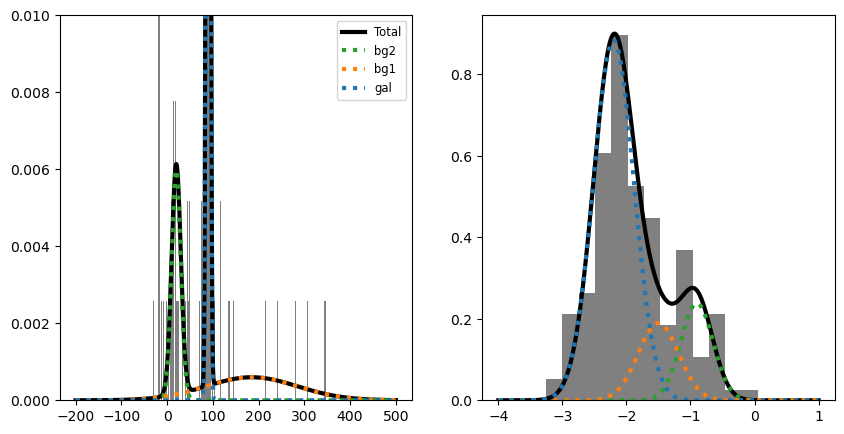

In [10]:
## I found this guess by looking at the plot by eye and estimating. This part requires some futzing.
p0_guess = [0.70, 0.50,
            90, 0.5, -2.2, -0.5,
            185, 2.0, -1.5, -0.5,
            20, 1.0, -0.9, -0.6]
fig = plot_1d_distrs(p0_guess)
fig.axes[0].set_ylim(0,0.01)

In [11]:
## Define a temporary function that is the negative of the log likelihood
## This is because the scipy optimizers minimize instead of maximize
optfunc = lambda theta: -lnprob(theta, rv, rverr, feh, feherr)
%time result = optimize.minimize(optfunc, p0_guess, method="Nelder-Mead")
print(result.message)

CPU times: user 941 ms, sys: 11.7 ms, total: 953 ms
Wall time: 960 ms
Maximum number of function evaluations has been exceeded.


In [12]:
## Print the result nicely
output = get_paramdict(result.x)
for label, value in output.items():
    print(label, value)

pgal 0.7178100162419156
pbg1 0.35364969855135747
vhel 89.12013080044008
lsigv 0.34432089165108337
feh -2.145586747218549
lsigfeh -0.4897034814790302
vbg1 146.6265823941486
lsigvbg1 2.031912718520776
fehbg1 -1.5799640123168874
lsigfeh1 -0.7002042030685902
vbg2 22.07696772840431
lsigvbg2 1.4861929898238868
fehbg2 -0.8868621302455695
lsigfeh2 -0.5979358069260527


It's always a good idea to project the parameters back into the observed space to see if it's doing a good job. This should be pretty close, otherwise emcee will never find your answer.
It's also a good way to debug your likelihood.

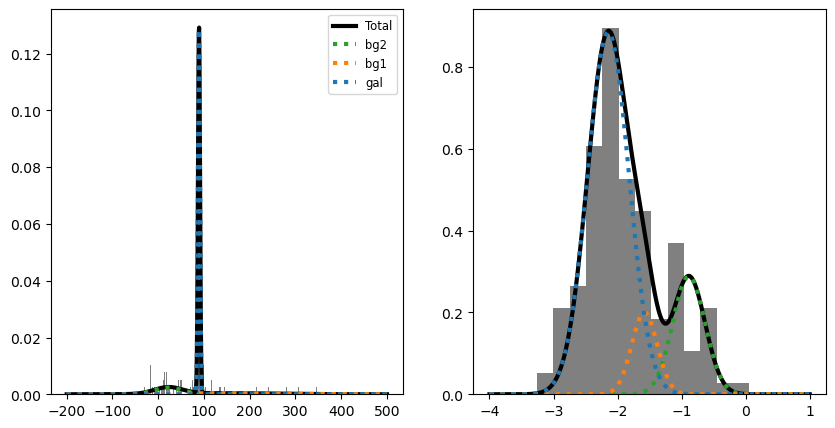

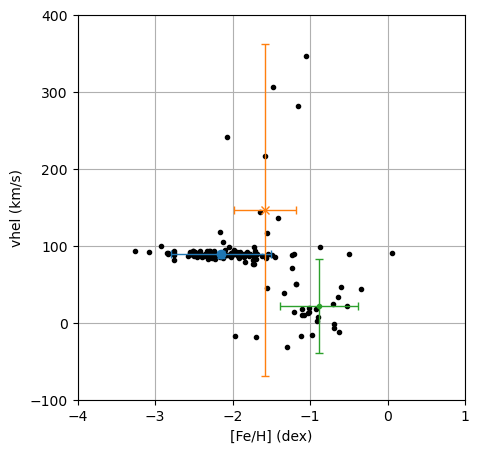

In [13]:
fig1 = plot_1d_distrs(result.x)
fig2 = plot_2d_distr(result.x)

# Run the sampler

In [14]:
nparams = len(param_labels)
print(nparams)
nwalkers = 64
p0 = result.x
ep0 = np.zeros(len(p0)) + 0.02 # some arbitrary width that's pretty close; scale accordingly to your expectation of the uncertainty
p0s = np.random.multivariate_normal(p0, np.diag(ep0)**2, size=nwalkers)
## Check to see things are initialized ok
lkhds = [lnprob(p0s[j], rv, rverr, feh, feherr) for j in range(nwalkers)]
assert np.all(np.array(lkhds) > -9e9)

14


On Alex's laptop, this next step takes about 2 minutes (2024: that was on intel, now it's 1 min on an M1)

In [15]:
%%time 
from schwimmbad import MultiPool

## Run emcee in parallel
nproc = 4
nstep = 2000

with MultiPool(nproc) as pool:
    print("Running burnin with {} iterations".format(nstep))
    start = time.time()
    es = emcee.EnsembleSampler(
        nwalkers, len(p0), lnprob, args=(rv, rverr, feh, feherr), pool=pool)
    PP = es.run_mcmc(p0s, nstep)
    print("Took {:.1f} seconds".format(time.time()-start))
    
    print(f"Now running the actual thing")
    es.reset()
    start = time.time()
    es.run_mcmc(PP.coords, nstep)
    print("Took {:.1f} seconds".format(time.time()-start))
    
    chain = es.chain
    # Can save this output with np.save

Running burnin with 2000 iterations
Took 34.2 seconds
Now running the actual thing
Took 34.5 seconds
CPU times: user 1min 2s, sys: 2.19 s, total: 1min 4s
Wall time: 1min 8s


The output here is the result of 64 different chains, each run for 2000 steps, for the 14 different input parameters

In [16]:
chain.shape

(64, 2000, 14)

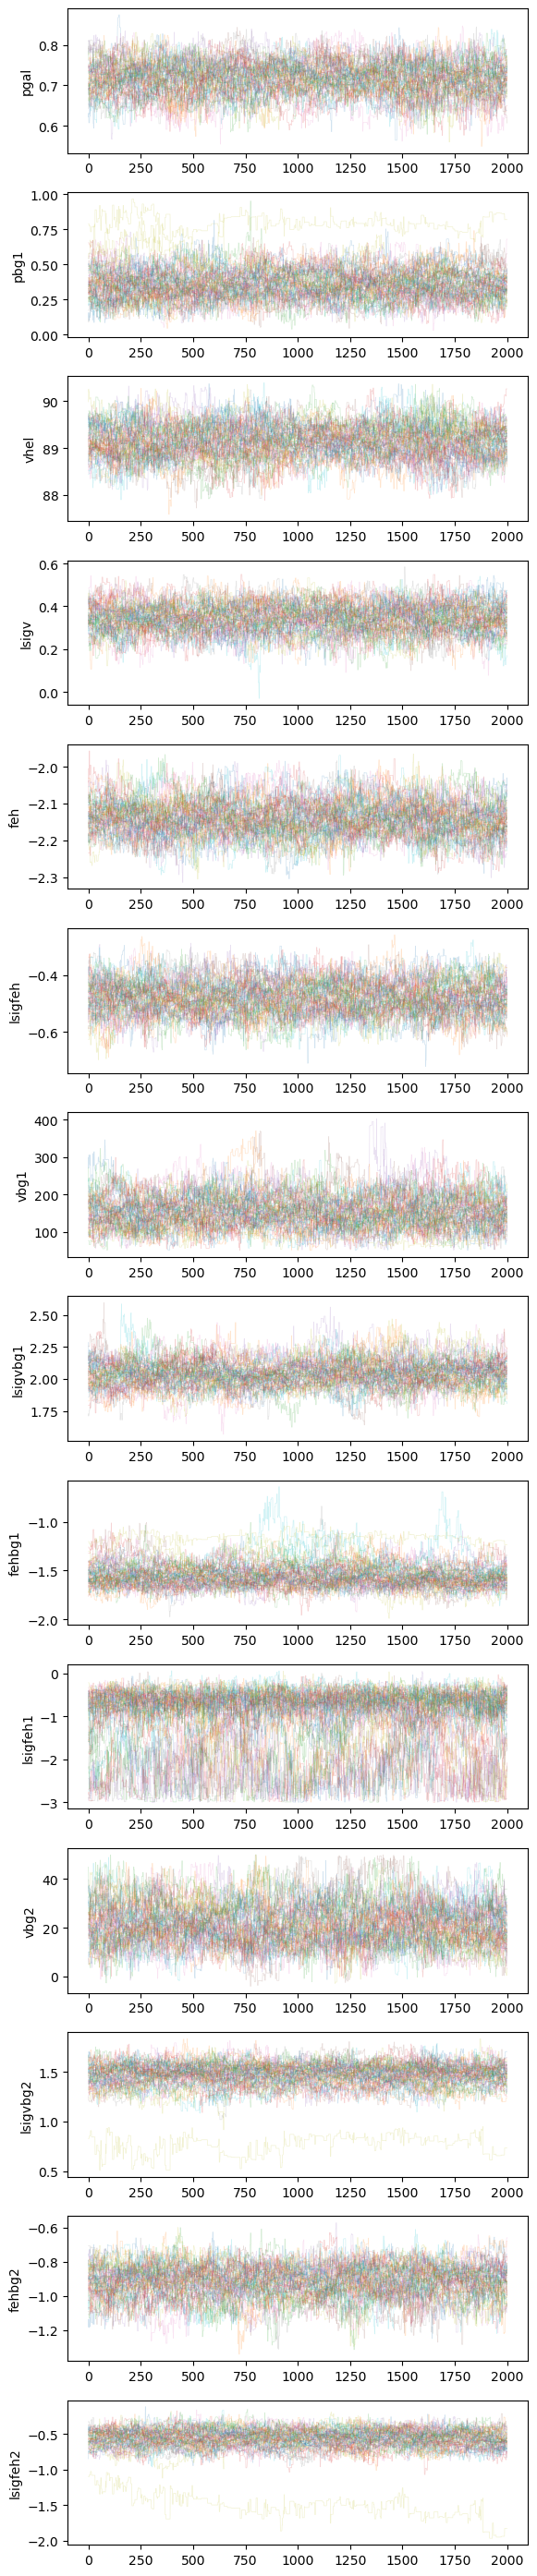

In [17]:
Nrow = chain.shape[2]
fig, axes = plt.subplots(Nrow, figsize=(6,2*Nrow))
for iparam,ax in enumerate(axes):
    for j in range(nwalkers):
        ax.plot(chain[j,:,iparam], lw=.5, alpha=.2)
        ax.set_ylabel(param_labels[iparam])
fig.tight_layout()

If things are well mixed, then you can just use the flat chain to concatenate all the walkers and steps.
The results here may not be perfectly mixed, but it's not terrible.
There are fancy ways to check things here involving autocorrelation times that Alex does not know about.
To me this is the hard part of emcee: knowing when you're happy with the result, and setting things up so that it gets there as fast as possible. This is why I prefer dynesty, even though it's slower it has a motivated stopping condition.

In [18]:
chain = es.flatchain
chain.shape

(128000, 14)

You can see the output of the fit as a corner plot. Basically you want everything to be nice and round, and if not that means you didn't initialize your walkers well enough or burn in for long enough.

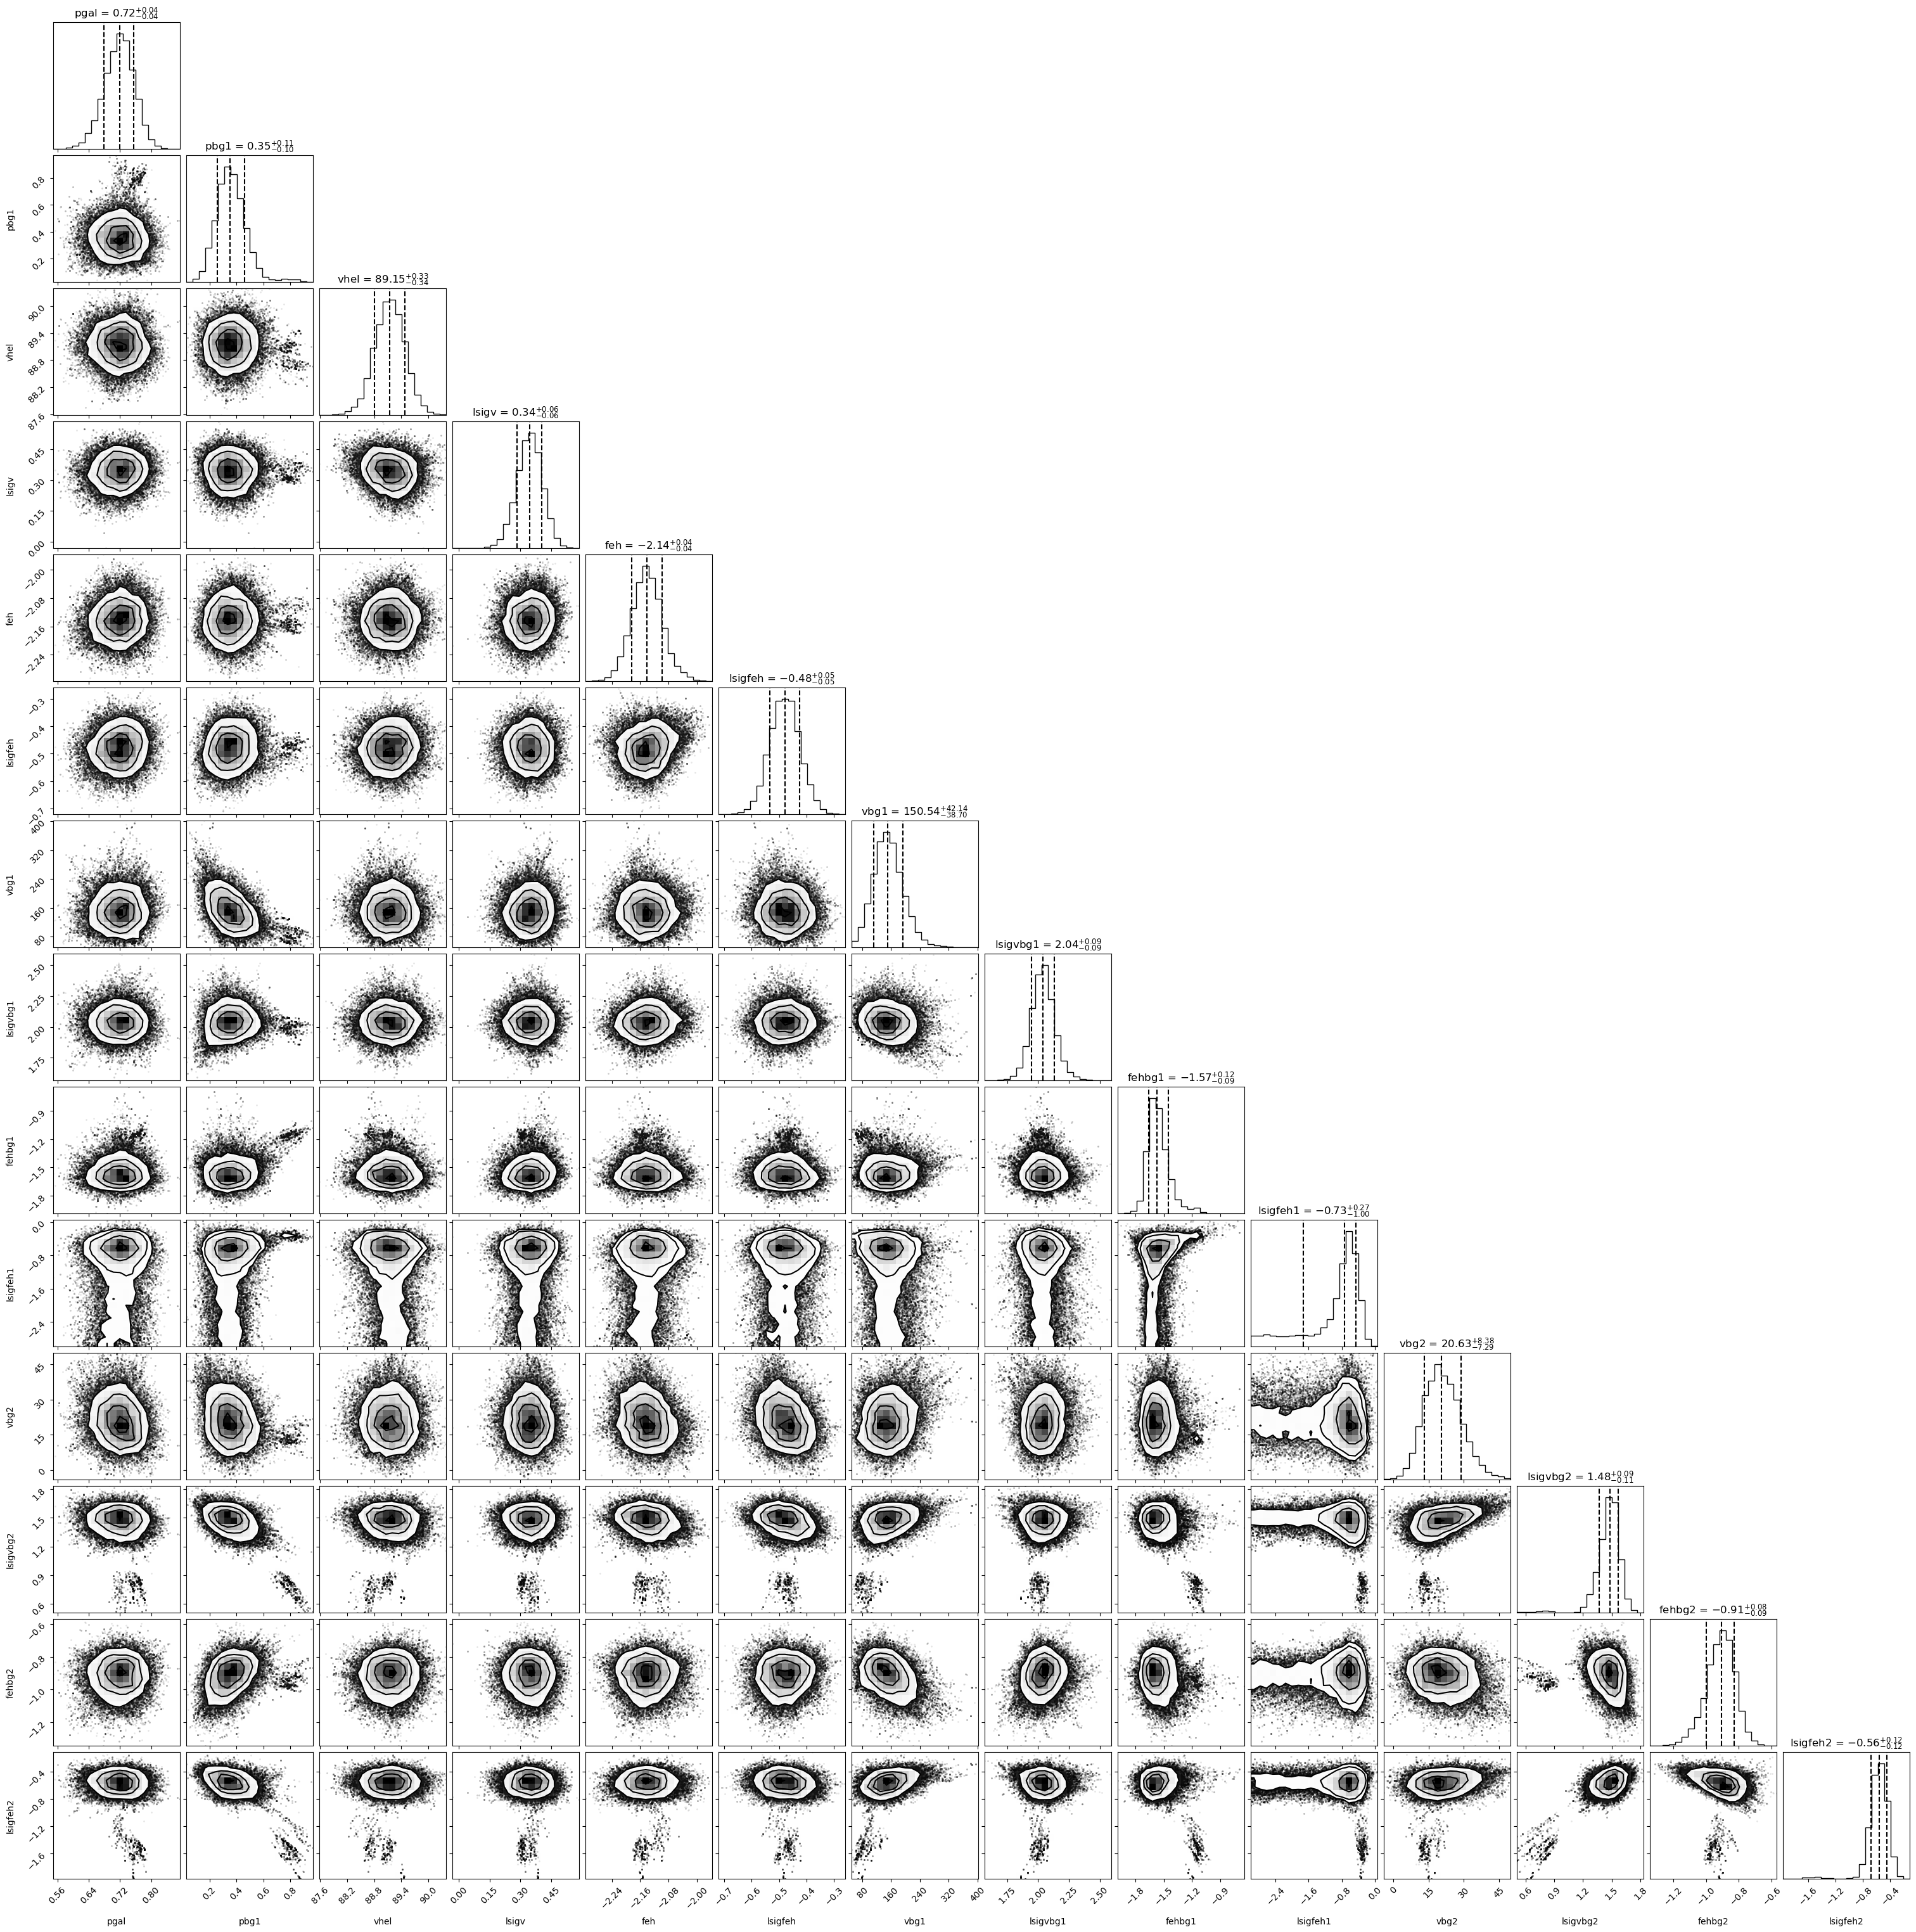

In [19]:
fig = corner.corner(chain, labels=param_labels, quantiles=[0.16,0.50,0.84], show_titles=True)

It's customary to summarize the data with percentiles, but you should check the corner plot diagonal to see if this is a good idea.

In [20]:
def process_chain(chain, avg_error=True):
    pctl = np.percentile(chain, [16, 50, 84], axis=0)
    meds = pctl[1]
    ep = pctl[2]-pctl[1]
    em = pctl[0]-pctl[1]
    if avg_error: # just for simplicity, assuming no asymmetry
        err = (ep-em)/2
        return OrderedDict(zip(param_labels, meds)), OrderedDict(zip(param_labels, err))
    else:
        return OrderedDict(zip(param_labels, meds)), OrderedDict(zip(param_labels, ep)), OrderedDict(zip(param_labels, em))

In [21]:
meds, errs = process_chain(chain)

In [22]:
for k,v in meds.items():
    print("{} {:.3f} {:.3f}".format(k, v, errs[k]))

pgal 0.720 0.038
pbg1 0.354 0.102
vhel 89.145 0.333
lsigv 0.345 0.061
feh -2.142 0.042
lsigfeh -0.479 0.054
vbg1 150.544 40.418
lsigvbg1 2.038 0.090
fehbg1 -1.573 0.103
lsigfeh1 -0.733 0.634
vbg2 20.634 7.832
lsigvbg2 1.480 0.100
fehbg2 -0.907 0.085
lsigfeh2 -0.563 0.119


Yay you are done! And now you can see the unusually low velocity dispersion of this galaxy:

In [23]:
10**meds["lsigv"]

2.2105709870594867